In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import regex as re
from shutil import copyfile

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# files_in_train = os.listdir('train')
# for counter,file in enumerate( files_in_train ):
#     if counter%100 == 0:
#         print(counter)
#     if re.search("dog.*",file):
#         copyfile('train/'+file,'all_files/dog/'+file)
#     else:
#         copyfile('train/'+file,'all_files/cat/'+file)

In [7]:
# image_size = (160, 160)
# image_size_rgb = image_size

image_path = "all_files"

image_size = (71, 71)
image_size_rgb = (71, 71)

batch_size = 32
seeds = 42

num_classes = 8
# num_classes = 2

validation_s = 0.2
labels = 'inferred'
label_mode="categorical"
# label_mode="int"


train_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3179 files belonging to 8 classes.
Using 2544 files for training.
Found 3179 files belonging to 8 classes.
Using 635 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['10', '12', '1235', '15', '17', '2', '21', '38']


In [10]:
buffer_size = 32

train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)

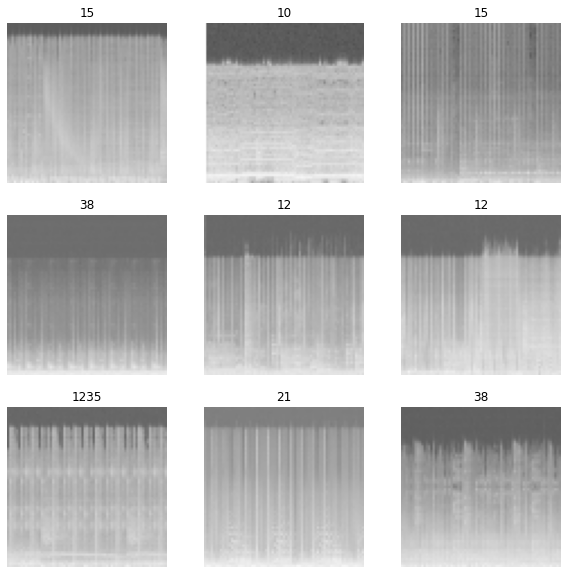

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
## Model parameters:
main_activation = "relu"
last_activation = "softmax"
bias = True
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = None
rescaling_layer = layers.Rescaling(scale=1.0 / 255)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3))

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-01-22 20:39:24.957068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 43 of 1000


0.33964399 0.9312897


2022-01-22 20:39:32.231666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [51]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 71, 71, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 71, 71, 16)        448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 35, 35, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 17, 17, 64)       

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
80/80 [==============================] - 9s 103ms/step - loss: 2.0277 - accuracy: 0.2068 - val_loss: 1.9722 - val_accuracy: 0.2488
Epoch 2/10
80/80 [==============================] - 8s 100ms/step - loss: 1.8174 - accuracy: 0.3160 - val_loss: 1.7964 - val_accuracy: 0.3260
Epoch 3/10
80/80 [==============================] - 10s 119ms/step - loss: 1.6469 - accuracy: 0.3962 - val_loss: 1.6688 - val_accuracy: 0.3906
Epoch 4/10
80/80 [==============================] - 8s 99ms/step - loss: 1.4377 - accuracy: 0.4776 - val_loss: 1.3530 - val_accuracy: 0.5244
Epoch 5/10
80/80 [==============================] - 9s 108ms/step - loss: 1.1889 - accuracy: 0.5853 - val_loss: 1.1590 - val_accuracy: 0.6063
Epoch 6/10
80/80 [==============================] - 9s 112ms/step - loss: 1.0160 - accuracy: 0.6439 - val_loss: 0.9500 - val_accuracy: 0.6850
Epoch 7/10
80/80 [==============================] - 8s 97ms/step - loss: 0.8231 - accuracy: 0.7142 - val_loss: 0.8261 - val_accuracy: 0.7134
Epoch 8

In [54]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(16, 3, padding='same', activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (3,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d_39 (Conv2D)          (None, 71, 71, 16)        448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 35, 35, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                     

In [55]:
model_bas.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
epochs=10
history = model_bas.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
80/80 [==============================] - 8s 90ms/step - loss: 2.0311 - accuracy: 0.1883 - val_loss: 2.0028 - val_accuracy: 0.1890
Epoch 2/10
80/80 [==============================] - 8s 105ms/step - loss: 1.9035 - accuracy: 0.2716 - val_loss: 1.8247 - val_accuracy: 0.2898
Epoch 3/10
80/80 [==============================] - 7s 90ms/step - loss: 1.7346 - accuracy: 0.3459 - val_loss: 1.7055 - val_accuracy: 0.3701
Epoch 4/10
80/80 [==============================] - 7s 87ms/step - loss: 1.6239 - accuracy: 0.4226 - val_loss: 1.6222 - val_accuracy: 0.4394
Epoch 5/10
80/80 [==============================] - 7s 86ms/step - loss: 1.4676 - accuracy: 0.4744 - val_loss: 1.4527 - val_accuracy: 0.4472
Epoch 6/10
80/80 [==============================] - 7s 82ms/step - loss: 1.2788 - accuracy: 0.5468 - val_loss: 1.2406 - val_accuracy: 0.5622
Epoch 7/10
80/80 [==============================] - 7s 85ms/step - loss: 1.0921 - accuracy: 0.6160 - val_loss: 1.1068 - val_accuracy: 0.6173
Epoch 8/10
8

****Modell fitting and validating****

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

In [ ]:
epochs = 30
# l_r = 0.0005



def modell_fit_val(models,model_names,l_r = 0.001,chanels = 3):
    if chanels == 3:
        fit_train_ds = train_ds
        fit_val_ds = val_ds

    #compile parameters
    opt = keras.optimizers.Adam(learning_rate=l_r)
    batch_size = 32
    loss = tf.keras.losses.BinaryCrossentropy()

    models_test_acc = []
    for models, model_name in zip(models,model_names):

        save_dir = "saves/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=4, min_delta=0.01,
            verbose=1
        )
        callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir + "_{epoch}.h5"),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        reducelr_callback]

        print("Training model: {} with learning rate: {}".format(model_name,l_r))

        models.compile(
            # optimizer=keras.optimizers.Adam(),
            optimizer=opt,
            loss=loss,
            metrics=["accuracy"]
        )
        models.fit(
            fit_train_ds, batch_size=batch_size, epochs=epochs, callbacks=callbacks, 
            validation_data=fit_val_ds, shuffle=True
        )
        test_loss, test_acc = models.evaluate(fit_val_ds, verbose=2)
        models_test_acc.append(test_acc)

    for counter, acc in enumerate(models_test_acc):
        print("the {}. model has an accuracyŰ of {}".format(counter,acc))

In [ ]:
# import mltest

# def test_my_model():
#   # Make placeholders for input into the model
#   input_image = tf.placeholder(...)
#   label = tf.placeholder(...)
#   # Build your model
#   model = Model(input_image, label)
#   # Run the test suite!
#   mltest.test_suite(
#     model.logits,
#     model.train_op,
#     feed_dict={
#       input_image: np.random.randn(...)
#       label: np.random.randint(...)
#     })

In [ ]:
for l_rate in [0.1,0.01,0.001,0.0001]:
    model_DNN = make_model_DNN(input_shape=image_size + (3,), num_classes=num_classes)
    model_bas = make_model_bas(input_shape=image_size + (3,), num_classes=num_classes)
    modell_fit_val([model_DNN,model_bas],['model_DNN','model_bas'],l_r=l_rate)

In [ ]:
for l_rate in [1,0.1,0.01,0.001,0.0001]:
    model_bas = make_model_bas(input_shape=image_size + (3,), num_classes=num_classes)
    model_adv_bas = make_model_adv_bas(input_shape=image_size + (3,), num_classes=num_classes)
    model_adv = make_model_adv(input_shape=image_size + (3,), num_classes=num_classes)
    modell_fit_val([model_bas,model_adv_bas,model_adv],['model_bas','model_adv_bas','model_adv'],l_r=l_rate)

In [ ]:
for l_rate in [0.01]:
    model_adv_bas = make_model_adv_bas(input_shape=image_size + (3,), num_classes=num_classes)
    modell_fit_val([model_adv_bas],['model_adv_bas'],l_r=l_rate)

In [ ]:
model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)
modell_fit_val([model_im_net],"model_im_net",chanels=3)

In [ ]:
def model_saver(models,names,path):
    for model, name in zip(models,names):
        model.save(os.path.join(path,name))

In [ ]:
# model_saver([model_im_net,model_adv],["model_im_net","model_adv"],"/home/vikichan/Documents/ta_labor/tester/modells/01_14/")